## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [22]:
output_units=10
num_neurons=[512, 256, 128]


from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units, num_neurons, ratio, ch):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if ch == 1:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1(ratio))(input_layer)
            elif ch == 2:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l2(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1_l2(ratio))(input_layer)
                
        else:
            if ch == 1:
                x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(ratio))(x)
            elif ch == 2:
                x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(ratio))(x)
            else:
                x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=ratio,l2=ratio))(x)
            
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [11]:
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
def Training_Model(LEARNING_RATE, EPOCHS, BATCH_SIZE, MOMENTUM, EXP, ch, results):
    for regulizer_ratio in EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
        model = build_mlp(x_train.shape[1:], output_units, num_neurons, regulizer_ratio, ch)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        
        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)
        
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
        
        shc = ""
        if ch == 1:
            sch = "L1"
        elif ch == 2:
            sch = "L2"
        else:
            sch = "L1_L2"
        exp_name_tag = "exp"+sch+"%s" % str(regulizer_ratio)   
        
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}


In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def Draw_Result(results):
    color_bar = ["r", "g", "b", "y", "m", "k"]
    
    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.title("Loss")
    plt.ylim([0, 5])
    plt.legend()
    plt.show()
        
    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title("Accuracy")
    plt.legend()
    plt.show()


In [13]:
results_L1 = {}
Training_Model(LEARNING_RATE, EPOCHS, BATCH_SIZE, MOMENTUM, EXP, 1, results_L1)

W0718 11:27:42.326367 19252 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0718 11:27:42.327338 19252 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0718 11:27:42.345289 19252 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 11:27:42.346288 19252 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 11:27:42.348284 19252 deprecation_wrapper.py:119] From D:\Anaconda3\li

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 107us/step - loss: 5.9974 - acc: 0.2781 - val_loss: 5.8058 - val_acc: 0.3426
Epoch 2/50
50000/50000 [==============================] - 5s 101us/step - loss: 5.7138 - acc: 0.3686 - val_loss: 5.6330 - val_acc: 0.3804
Epoch 3/50
50000/50000 [==============================] - 5s 102us/step - loss: 5.5692 - acc: 0.3976 - val_loss: 5.5068 - val_acc: 0.4083
Epoch 4/50
50000/50000 [==============================] - 5s 101us/step - loss: 5.4515 - acc: 0.4151 - val_loss: 5.3911 - val_acc: 0.4270
Epoch 5/50
50000/50000 [==============================] - 5s 101us/step - loss: 5.3405 - acc: 0.4315 - val_loss: 5.2959 - val_acc: 0.4399
Epoch 6/50
50000/50000 [==============================] - 5s 101us/step - loss: 5.2394 - acc: 0.4458 - val_loss: 5.2041 - val_acc: 0.4439
Epoch 7/50
50000/50000 [==============================] - 5s 101us/step - loss: 5.1441 - acc: 0.4560 - val_loss: 5.1195 - 

Epoch 2/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.8034 - acc: 0.3669 - val_loss: 1.7558 - val_acc: 0.3886
Epoch 3/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.7176 - acc: 0.3983 - val_loss: 1.6828 - val_acc: 0.4138
Epoch 4/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.6572 - acc: 0.4180 - val_loss: 1.6438 - val_acc: 0.4198
Epoch 5/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.6112 - acc: 0.4350 - val_loss: 1.5964 - val_acc: 0.4383
Epoch 6/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.5718 - acc: 0.4483 - val_loss: 1.5749 - val_acc: 0.4387
Epoch 7/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.5380 - acc: 0.4590 - val_loss: 1.5474 - val_acc: 0.4500
Epoch 8/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.5093 - acc: 0.4682 - val_loss: 1.5338 - val_acc: 0.4554
Epoch 9/50
50000/50000 [==========

50000/50000 [==============================] - 5s 103us/step - loss: 1.7158 - acc: 0.3973 - val_loss: 1.6861 - val_acc: 0.4060
Epoch 4/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.6547 - acc: 0.4207 - val_loss: 1.6311 - val_acc: 0.4256
Epoch 5/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.6059 - acc: 0.4378 - val_loss: 1.5923 - val_acc: 0.4402
Epoch 6/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.5675 - acc: 0.4510 - val_loss: 1.5669 - val_acc: 0.4478
Epoch 7/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.5335 - acc: 0.4622 - val_loss: 1.5394 - val_acc: 0.4564
Epoch 8/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.5053 - acc: 0.4724 - val_loss: 1.5389 - val_acc: 0.4561
Epoch 9/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.4768 - acc: 0.4807 - val_loss: 1.4981 - val_acc: 0.4694
Epoch 10/50
50000/50000 [====================

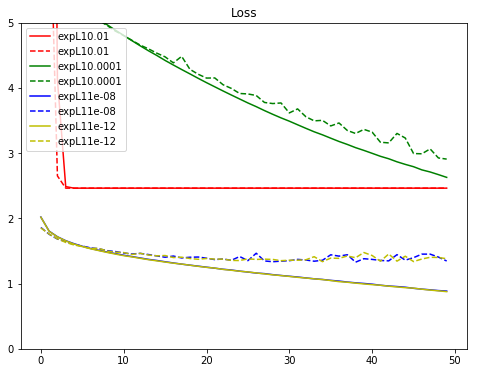

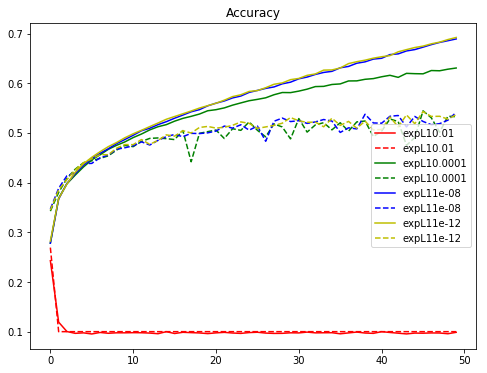

In [17]:
Draw_Result(results_L1)

In [18]:
results_L2 = {}
Training_Model(LEARNING_RATE, EPOCHS, BATCH_SIZE, MOMENTUM, EXP, 2, results_L2)

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 106us/step - loss: 2.1565 - acc: 0.2795 - val_loss: 1.9885 - val_acc: 0.3480
Epoch 2/50
50000/50000 [==============================] - 5s 99us/step - loss: 1.9372 - acc: 0.3708 - val_loss: 1.8973 - val_acc: 0.3839
Epoch 3/50
50000/50000 [==============================] - 5s 99us/step - loss: 1.8599 - acc: 0.3986 - val_loss: 1.8275 - val_acc: 0.4072
Epoch 4/50
50000/50000 [==============================] - 5s 99us/step - loss: 1.8023 - acc: 0.4171 - val_loss: 1.7772 - val_acc: 0.4258
Epoch 5/50
50000/50000 [==============================] - 5s 99us/step - loss: 1.7536 - acc: 0.4364 - val_loss: 1.7453 - val_acc: 0.4332
Epoch 6/50
50000/50000 [==============================] - 5s 99us/step - loss: 1.7121 - acc: 0.4511 - val_loss: 1.7141 - val_acc: 0.4475
Epoch 7/50
50000/50000 [==============================] - 5s 100us/step - loss: 1.6773 - acc: 0.4613 - val_loss: 1.6969 - val_a

Epoch 2/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.8132 - acc: 0.3654 - val_loss: 1.7745 - val_acc: 0.3860
Epoch 3/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.7276 - acc: 0.3974 - val_loss: 1.6900 - val_acc: 0.4063
Epoch 4/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.6678 - acc: 0.4164 - val_loss: 1.6543 - val_acc: 0.4224
Epoch 5/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.6216 - acc: 0.4310 - val_loss: 1.6101 - val_acc: 0.4335
Epoch 6/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.5816 - acc: 0.4442 - val_loss: 1.5741 - val_acc: 0.4508
Epoch 7/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.5515 - acc: 0.4555 - val_loss: 1.5475 - val_acc: 0.4588
Epoch 8/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.5207 - acc: 0.4676 - val_loss: 1.5277 - val_acc: 0.4614
Epoch 9/50
50000/50000 [==========

50000/50000 [==============================] - 5s 101us/step - loss: 1.7161 - acc: 0.3996 - val_loss: 1.6879 - val_acc: 0.4114
Epoch 4/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.6600 - acc: 0.4180 - val_loss: 1.6335 - val_acc: 0.4320
Epoch 5/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.6129 - acc: 0.4353 - val_loss: 1.6007 - val_acc: 0.4416
Epoch 6/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.5728 - acc: 0.4491 - val_loss: 1.5705 - val_acc: 0.4482
Epoch 7/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.5373 - acc: 0.4616 - val_loss: 1.5466 - val_acc: 0.4492
Epoch 8/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.5072 - acc: 0.4713 - val_loss: 1.5196 - val_acc: 0.4661
Epoch 9/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.4791 - acc: 0.4817 - val_loss: 1.4872 - val_acc: 0.4773
Epoch 10/50
50000/50000 [====================

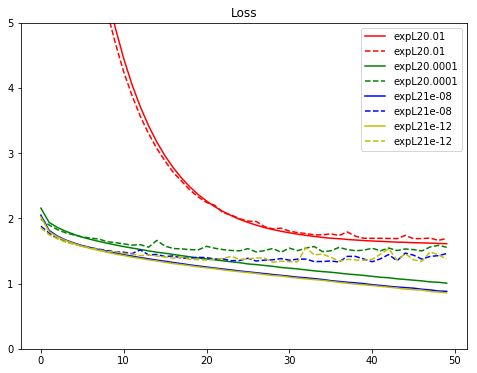

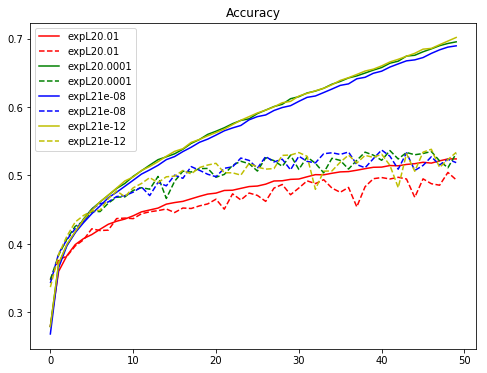

In [19]:
Draw_Result(results_L2)

In [20]:
results_L1_L2 = {}
Training_Model(LEARNING_RATE, EPOCHS, BATCH_SIZE, MOMENTUM, EXP, 12, results_L1_L2)

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 126us/step - loss: 18.7771 - acc: 0.2795 - val_loss: 17.3505 - val_acc: 0.3423
Epoch 2/50
50000/50000 [==============================] - 6s 118us/step - loss: 16.1282 - acc: 0.3581 - val_loss: 14.9712 - val_acc: 0.3694
Epoch 3/50
50000/50000 [==============================] - 6s 118us/step - loss: 13.9436 - acc: 0.3809 - val_loss: 12.9696 - val_acc: 0.3848
Epoch 4/50
50000/50000 [==============================] - 6s 118us/step - loss: 12.0963 - acc: 0.3946 - val_loss: 11.2587 - val_acc: 0.4030
Epoch 5/50
50000/50000 [==============================] - 6s 118us/step - loss: 10.5249 - acc: 0.4047 - val_loss: 9.8204 - val_acc: 0.4073
Epoch 6/50
50000/50000 [==============================] - 6s 118us/step - loss: 9.1871 - acc: 0.4140 - val_loss: 8.5836 - val_acc: 0.4146
Epoch 7/50
50000/50000 [==============================] - 6s 118us/step - loss: 8.0498 - acc: 0.4192 - val_loss: 

Epoch 2/50
50000/50000 [==============================] - 6s 120us/step - loss: 13.0108 - acc: 0.3502 - val_loss: 12.1196 - val_acc: 0.3695
Epoch 3/50
50000/50000 [==============================] - 6s 120us/step - loss: 11.3372 - acc: 0.3756 - val_loss: 10.5930 - val_acc: 0.3804
Epoch 4/50
50000/50000 [==============================] - 6s 119us/step - loss: 9.9262 - acc: 0.3908 - val_loss: 9.2886 - val_acc: 0.3989
Epoch 5/50
50000/50000 [==============================] - 6s 119us/step - loss: 8.7274 - acc: 0.4005 - val_loss: 8.1899 - val_acc: 0.4065
Epoch 6/50
50000/50000 [==============================] - 6s 119us/step - loss: 7.7067 - acc: 0.4070 - val_loss: 7.2572 - val_acc: 0.4039
Epoch 7/50
50000/50000 [==============================] - 6s 119us/step - loss: 6.8355 - acc: 0.4158 - val_loss: 6.4444 - val_acc: 0.4171
Epoch 8/50
50000/50000 [==============================] - 6s 121us/step - loss: 6.0910 - acc: 0.4237 - val_loss: 5.7604 - val_acc: 0.4176
Epoch 9/50
50000/50000 [======

50000/50000 [==============================] - 6s 119us/step - loss: 11.3355 - acc: 0.3826 - val_loss: 10.5858 - val_acc: 0.3950
Epoch 4/50
50000/50000 [==============================] - 6s 119us/step - loss: 9.9240 - acc: 0.3974 - val_loss: 9.2879 - val_acc: 0.4052
Epoch 5/50
50000/50000 [==============================] - 6s 120us/step - loss: 8.7246 - acc: 0.4087 - val_loss: 8.1814 - val_acc: 0.4122
Epoch 6/50
50000/50000 [==============================] - 6s 119us/step - loss: 7.7033 - acc: 0.4163 - val_loss: 7.2393 - val_acc: 0.4205
Epoch 7/50
50000/50000 [==============================] - 6s 119us/step - loss: 6.8312 - acc: 0.4221 - val_loss: 6.4389 - val_acc: 0.4278
Epoch 8/50
50000/50000 [==============================] - 6s 119us/step - loss: 6.0874 - acc: 0.4291 - val_loss: 5.7546 - val_acc: 0.4268
Epoch 9/50
50000/50000 [==============================] - 6s 120us/step - loss: 5.4530 - acc: 0.4338 - val_loss: 5.1694 - val_acc: 0.4334
Epoch 10/50
50000/50000 [==================

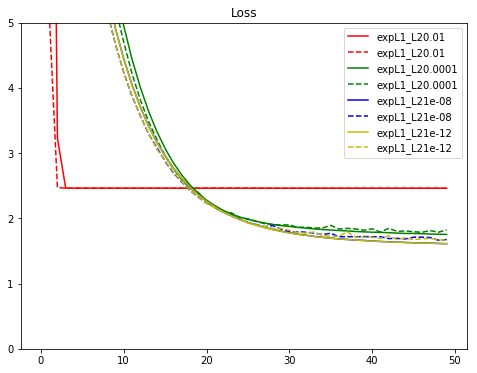

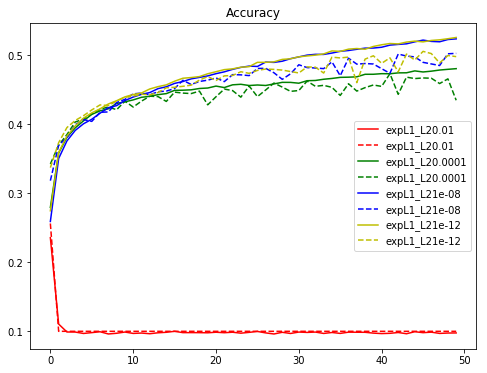

In [21]:
# kernel_regularizer=l1_l2(ratio)
Draw_Result(results_L1_L2)

In [23]:
results_L1_L2 = {}
Training_Model(LEARNING_RATE, EPOCHS, BATCH_SIZE, MOMENTUM, EXP, 12, results_L1_L2)

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 129us/step - loss: 14.0805 - acc: 0.2805 - val_loss: 13.0426 - val_acc: 0.3426
Epoch 2/50
50000/50000 [==============================] - 6s 120us/step - loss: 12.1963 - acc: 0.3620 - val_loss: 11.3800 - val_acc: 0.3794
Epoch 3/50
50000/50000 [==============================] - 6s 120us/step - loss: 10.6699 - acc: 0.3920 - val_loss: 9.9836 - val_acc: 0.4008
Epoch 4/50
50000/50000 [==============================] - 6s 120us/step - loss: 9.3815 - acc: 0.4105 - val_loss: 8.8026 - val_acc: 0.4128
Epoch 5/50
50000/50000 [==============================] - 6s 118us/step - loss: 8.2845 - acc: 0.4248 - val_loss: 7.7934 - val_acc: 0.4291
Epoch 6/50
50000/50000 [==============================] - 6s 118us/step - loss: 7.3494 - acc: 0.4378 - val_loss: 6.9349 - val_acc: 0.4384
Epoch 7/50
50000/50000 [==============================] - 6s 120us/step - loss: 6.5518 - acc: 0.4497 - val_loss: 6.21

Epoch 2/50
50000/50000 [==============================] - 6s 121us/step - loss: 8.8523 - acc: 0.3690 - val_loss: 8.2691 - val_acc: 0.3797
Epoch 3/50
50000/50000 [==============================] - 6s 120us/step - loss: 7.7507 - acc: 0.3978 - val_loss: 7.2556 - val_acc: 0.4103
Epoch 4/50
50000/50000 [==============================] - 6s 123us/step - loss: 6.8220 - acc: 0.4205 - val_loss: 6.4101 - val_acc: 0.4261
Epoch 5/50
50000/50000 [==============================] - 6s 120us/step - loss: 6.0326 - acc: 0.4354 - val_loss: 5.6847 - val_acc: 0.4360
Epoch 6/50
50000/50000 [==============================] - 6s 120us/step - loss: 5.3597 - acc: 0.4491 - val_loss: 5.0615 - val_acc: 0.4463
Epoch 7/50
50000/50000 [==============================] - 6s 120us/step - loss: 4.7855 - acc: 0.4585 - val_loss: 4.5384 - val_acc: 0.4562
Epoch 8/50
50000/50000 [==============================] - 6s 121us/step - loss: 4.2943 - acc: 0.4703 - val_loss: 4.0966 - val_acc: 0.4599
Epoch 9/50
50000/50000 [==========

50000/50000 [==============================] - 6s 119us/step - loss: 7.7509 - acc: 0.3986 - val_loss: 7.2519 - val_acc: 0.4198
Epoch 4/50
50000/50000 [==============================] - 6s 118us/step - loss: 6.8220 - acc: 0.4200 - val_loss: 6.4026 - val_acc: 0.4335
Epoch 5/50
50000/50000 [==============================] - 6s 118us/step - loss: 6.0328 - acc: 0.4352 - val_loss: 5.6969 - val_acc: 0.4351
Epoch 6/50
50000/50000 [==============================] - 6s 119us/step - loss: 5.3602 - acc: 0.4461 - val_loss: 5.0728 - val_acc: 0.4518
Epoch 7/50
50000/50000 [==============================] - 6s 118us/step - loss: 4.7867 - acc: 0.4588 - val_loss: 4.5507 - val_acc: 0.4551
Epoch 8/50
50000/50000 [==============================] - 6s 118us/step - loss: 4.2967 - acc: 0.4676 - val_loss: 4.1070 - val_acc: 0.4623
Epoch 9/50
50000/50000 [==============================] - 6s 119us/step - loss: 3.8754 - acc: 0.4761 - val_loss: 3.7310 - val_acc: 0.4566
Epoch 10/50
50000/50000 [====================

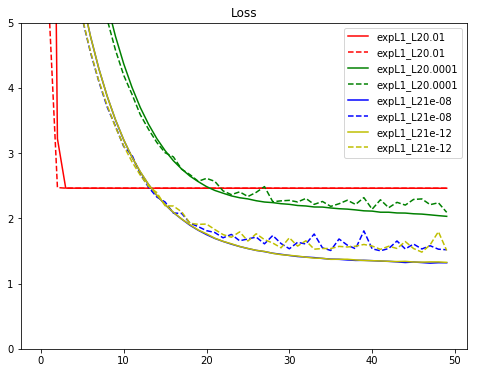

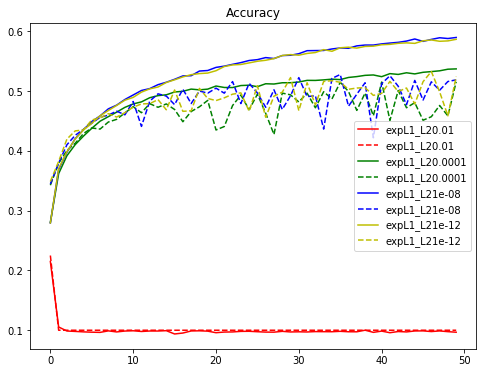

In [24]:
# kernel_regularizer=l1_l2(l1=ratio,l2=ratio)
Draw_Result(results_L1_L2)